##Imports


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import sys

# Add the src directory to the system path
src_path = '/content/drive/MyDrive/Signature_Project/src'
if src_path not in sys.path:
    sys.path.append(src_path)

from preprocess import preprocess_image
from features import extract_features

Mounted at /content/drive


##Paths

In [ ]:
DATA_DIR = os.path.join('/content/drive/MyDrive/Signature_Project/data', "signatures")
GENUINE_DIR = os.path.join(DATA_DIR, "full_org")
FORGED_DIR = os.path.join(DATA_DIR, "full_forg")

def load_dataset():
    X, y = [], []
    for path, label in [(GENUINE_DIR, 1), (FORGED_DIR, 0)]:
        for f in os.listdir(path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                X.append(os.path.join(path, f))
                y.append(label)
    return X, np.array(y)

image_paths, labels = load_dataset()
print(f"Loaded {len(image_paths)} images (genuine={np.sum(labels == 1)}, forged={np.sum(labels == 0)})")

Loaded 2640 images (genuine=1320, forged=1320)


##Load images and labels

In [ ]:
def load_dataset():
    X, y = [], []
    for path, label in [(GENUINE_DIR, 1), (FORGED_DIR, 0)]:
        for f in os.listdir(path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                X.append(os.path.join(path, f))
                y.append(label)
    return X, np.array(y)

image_paths, labels = load_dataset()

##Preprocess and extract features

In [ ]:
features = []
for path in image_paths:
    img = preprocess_image(path)
    feat = extract_features(img)
    features.append(feat)

X = np.array(features)
y = labels

print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (2640, 3795)


##EDA

 Dataset loaded for EDA
Shape: (2640, 3796)
label
1    1320
0    1320
Name: count, dtype: int64


/tmp/ipython-input-3588963535.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


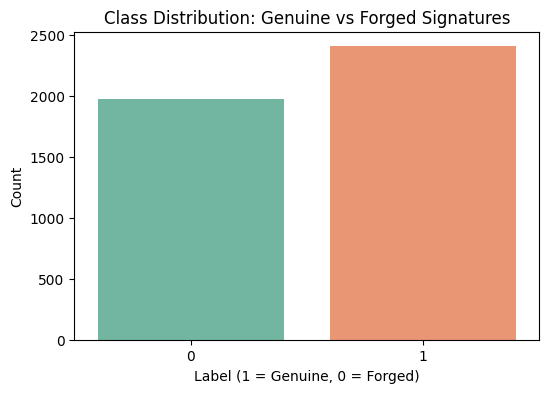


 Basic Statistical Summary:


,count,mean,std,min,25%,50%,75%,max
0,2640.0,1589.705492,1388.103350,94.500000,687.500000,1174.250000,2008.875000,12406.500000
1,2640.0,1.657298,0.965454,0.051724,0.926142,1.455051,2.201020,6.576923
2,2640.0,0.171294,0.101988,0.018402,0.100136,0.148155,0.214456,0.728765
3,2640.0,1.124582,1.343002,0.229051,0.475046,0.733073,1.324972,42.258727
4,2640.0,0.955146,0.507363,0.265676,0.578161,0.831259,1.160820,4.284017
5,2640.0,0.005623,0.048262,0.000000,0.000000,0.000000,0.000000,0.707107
6,2640.0,0.001719,0.018927,0.000000,0.000000,0.000000,0.000000,0.348826
7,2640.0,0.003739,0.033698,0.000000,0.000000,0.000000,0.000000,0.521025
8,2640.0,0.001012,0.011074,0.000000,0.000000,0.000000,0.000000,0.242195
9,2640.0,0.003531,0.030493,0.000000,0.000000,0.000000,0.000000,0.707107


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


# Convert feature matrix and labels into a DataFrame

df = pd.DataFrame(X)
df['label'] = y

print(" Dataset loaded for EDA")
print("Shape:", df.shape)
print(df['label'].value_counts())


# Class Distribution

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title("Class Distribution: Genuine vs Forged Signatures")
plt.xlabel("Label (1 = Genuine, 0 = Forged)")
plt.ylabel("Count")
plt.show()


# Feature Statistics Overview

print("\n Basic Statistical Summary:")
display(df.describe().T.head(10))


# Correlation Heatmap (sampled for speed)

sample_df = df.sample(min(1000, len(df)), random_state=42)
corr = sample_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap (sampled)")
plt.show()


# PCA Visualization (2D)

print("Performing PCA for 2D visualization...")
pca_vis = PCA(n_components=2)
X_pca = pca_vis.fit_transform(X)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, alpha=0.6, palette='coolwarm')
plt.title("2D PCA Visualization of Signature Feature Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Label", labels=["Forged (0)", "Genuine (1)"])
plt.show()


#PCA Explained Variance (how many components matter)

pca_full = PCA().fit(X)

plt.figure(figsize=(7,4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()



##train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (2112, 3795)
Testing data shape: (528, 3795)


##Pipelines and training



Training LogisticRegression...
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       264
           1       0.76      0.80      0.78       264

    accuracy                           0.77       528
   macro avg       0.78      0.77      0.77       528
weighted avg       0.78      0.77      0.77       528

AUC: 0.8524


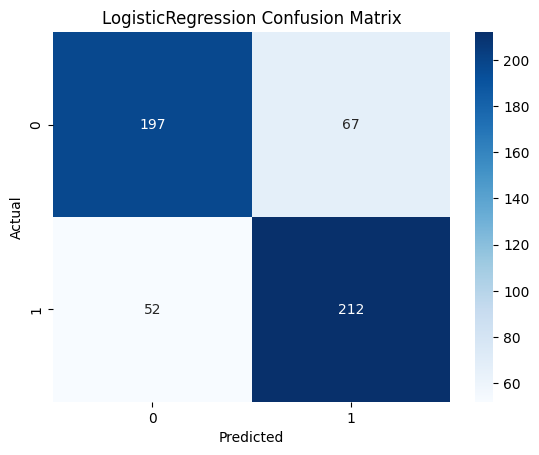


Training SVM...
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       264
           1       0.89      0.88      0.88       264

    accuracy                           0.88       528
   macro avg       0.88      0.88      0.88       528
weighted avg       0.88      0.88      0.88       528

AUC: 0.9549


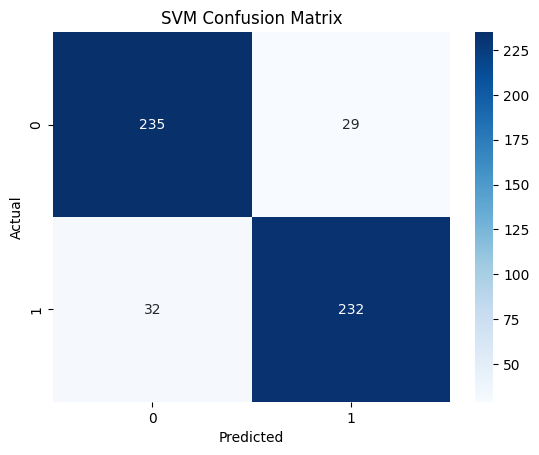


Training DecisionTree...
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       264
           1       0.70      0.73      0.71       264

    accuracy                           0.71       528
   macro avg       0.71      0.71      0.71       528
weighted avg       0.71      0.71      0.71       528

AUC: 0.6958


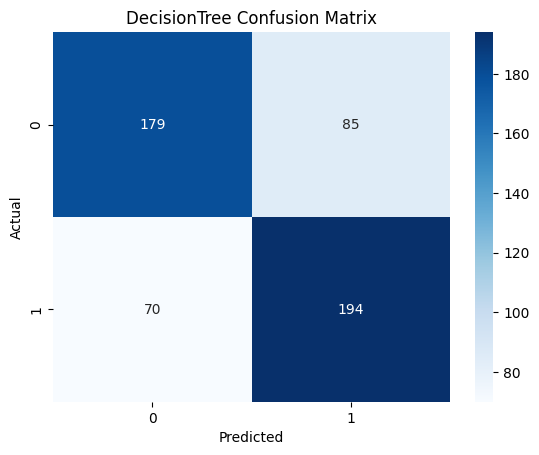


Training SGDClassifier...
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       264
           1       0.78      0.77      0.77       264

    accuracy                           0.78       528
   macro avg       0.78      0.78      0.78       528
weighted avg       0.78      0.78      0.78       528

AUC: 0.8116


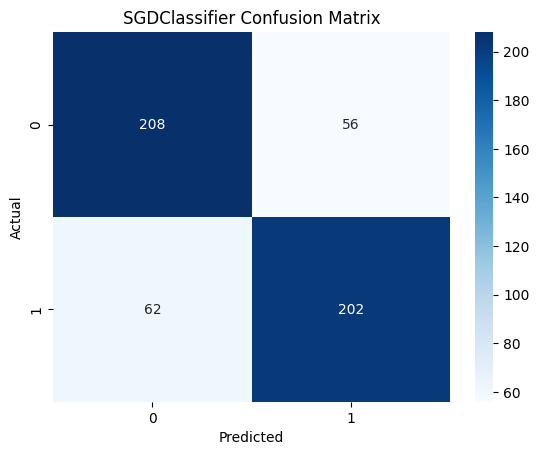

Equal Error Rate (EER) for the best model (SVM): 11.74%


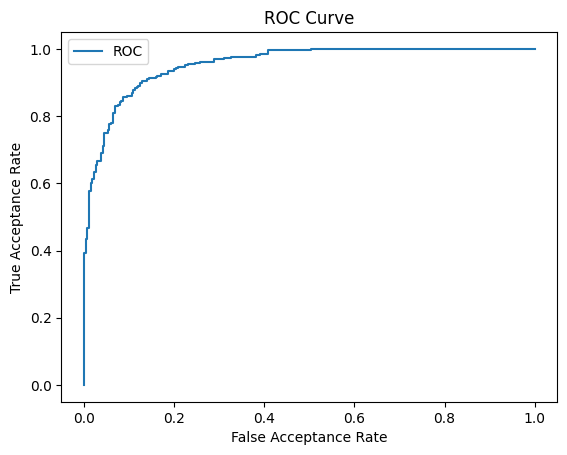

Model saved at ../models/best_signature_model.joblib


In [ ]:
# Define pipelines
def make_pipeline(model):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('clf', model)
    ])

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced'),
    "DecisionTree": DecisionTreeClassifier(max_depth=10, class_weight='balanced'),
    "SGDClassifier": SGDClassifier(loss='log_loss', max_iter=1000, class_weight='balanced')
}


results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    pipe = make_pipeline(model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None

    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    print(f"AUC: {auc:.4f}" if auc else "No probability output for AUC.")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

    results[name] = {"model": pipe, "AUC": auc}


best_model_name = max(results.items(), key=lambda kv: kv[1]["AUC"] if kv[1]["AUC"] else 0)[0]
best_model = results[best_model_name]["model"]
y_score = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thr = roc_curve(y_test, y_score)
FAR = fpr
FRR = 1 - tpr
eer_index = np.argmin(np.abs(FAR - FRR))
EER = (FAR[eer_index] + FRR[eer_index]) / 2
print(f"Equal Error Rate (EER) for the best model ({best_model_name}): {EER*100:.2f}%")

plt.plot(FAR, 1-FRR, label='ROC')
plt.xlabel('False Acceptance Rate')
plt.ylabel('True Acceptance Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


os.makedirs("../models", exist_ok=True)
joblib.dump(best_model, "../models/best_signature_model.joblib")
print("Model saved at ../models/best_signature_model.joblib")

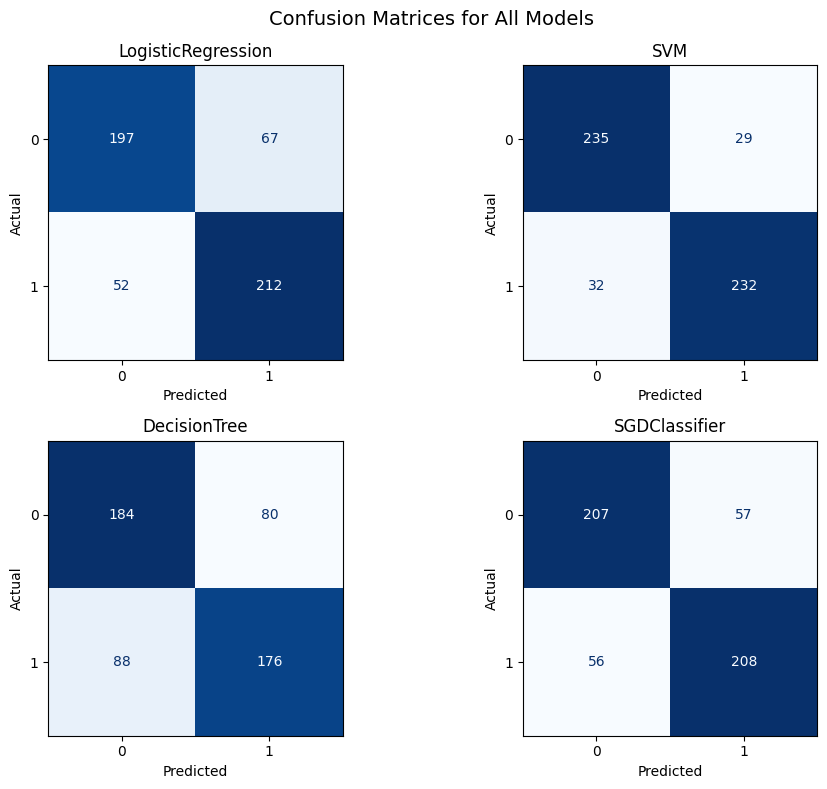

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


n_models = len(results)
cols = 2
rows = (n_models + 1) // 2


fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
axes = axes.flatten()

for idx, (name, info) in enumerate(results.items()):
    model = info["model"]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False)
    axes[idx].set_title(f"{name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")


for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Confusion Matrices for All Models", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd


confusion_results = {}

for name, res in results.items():
    model = res["model"]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        confusion_results[name] = {
            "True Positive (TP)": tp,
            "False Positive (FP)": fp,
            "False Negative (FN)": fn,
            "True Negative (TN)": tn
        }
    else:
        print(f" Skipping {name}: not a binary confusion matrix")

confusion_df = pd.DataFrame(confusion_results).T
print(" Confusion Matrix Breakdown per Model:")
display(confusion_df)


 Confusion Matrix Breakdown per Model:


,True Positive (TP),False Positive (FP),False Negative (FN),True Negative (TN)
LogisticRegression,212,67,52,197
SVM,232,29,32,235
DecisionTree,176,80,88,184
SGDClassifier,208,57,56,207


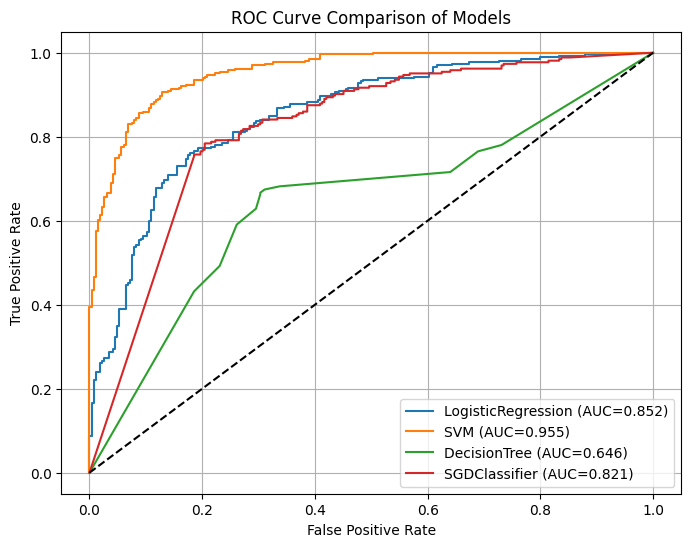

,Accuracy,Precision,Recall,F1-Score,AUC
Model,,,,,
LogisticRegression,0.775,0.760,0.803,0.781,0.852
SVM,0.884,0.889,0.879,0.884,0.955
DecisionTree,0.682,0.688,0.667,0.677,0.646
SGDClassifier,0.786,0.785,0.788,0.786,0.821


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

metrics_summary = []

plt.figure(figsize=(8,6))
for name, info in results.items():
    model = info["model"]

    # Predictions & probabilities
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = None

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    metrics_summary.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC": auc
    })

    # Plot ROC curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Models")
plt.legend()
plt.grid(True)
plt.show()

# --- Create and display metrics table ---
df_metrics = pd.DataFrame(metrics_summary)
df_metrics.set_index("Model", inplace=True)
display(df_metrics.style.format({
    "Accuracy": "{:.3f}",
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1-Score": "{:.3f}",
    "AUC": "{:.3f}"
}).set_properties(**{'text-align': 'center'}))

##Model performance Evaluation on test set

Model Performance Summary:


,Accuracy,Precision,Recall,F1 Score,AUC
LogisticRegression,0.775,0.760,0.803,0.781,0.852
SVM,0.884,0.889,0.879,0.884,0.955
DecisionTree,0.682,0.688,0.667,0.677,0.646
SGDClassifier,0.786,0.785,0.788,0.786,0.821


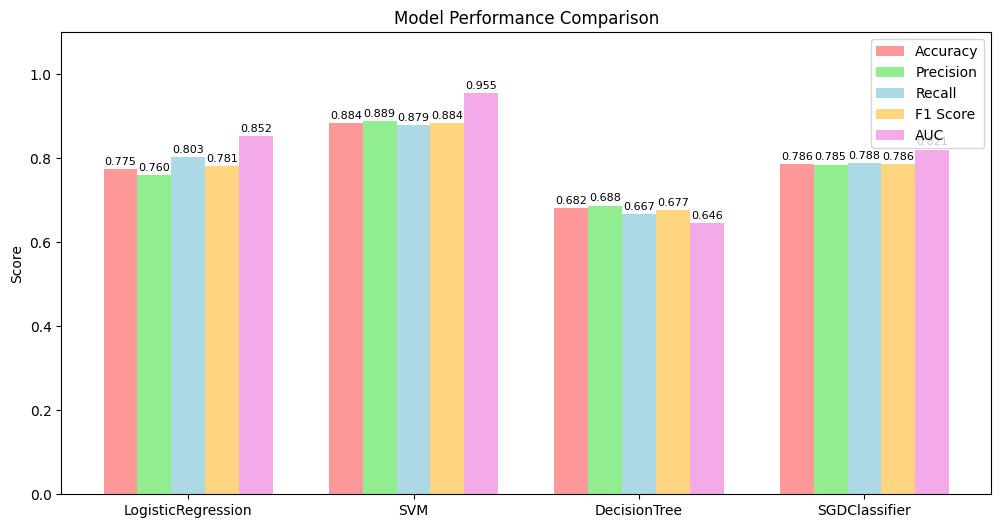

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


performance = {}

for name, res in results.items():
    model = res["model"]
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    performance[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    }


perf_df = pd.DataFrame(performance).T
print("Model Performance Summary:")
display(perf_df.round(3))

plt.figure(figsize=(12,6))
bar_width = 0.15
x = np.arange(len(perf_df.index))

colors = ['#FF9999','#90EE90','#ADD8E6','#FFD580','#F4A9E8']
metrics = ["Accuracy","Precision","Recall","F1 Score","AUC"]

for i, metric in enumerate(metrics):
    plt.bar(x + i*bar_width, perf_df[metric], width=bar_width, label=metric, color=colors[i])
    for j, val in enumerate(perf_df[metric]):
        plt.text(x[j] + i*bar_width, val + 0.01, f"{val:.3f}", ha='center', fontsize=8)

plt.xticks(x + bar_width*(len(metrics)/2 - 0.5), perf_df.index)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.ylim(0, 1.1)
plt.show()

Model loaded successfully.

Classification Report for the loaded model:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       264
           1       0.89      0.88      0.88       264

    accuracy                           0.88       528
   macro avg       0.88      0.88      0.88       528
weighted avg       0.88      0.88      0.88       528

AUC for the loaded model: 0.9549


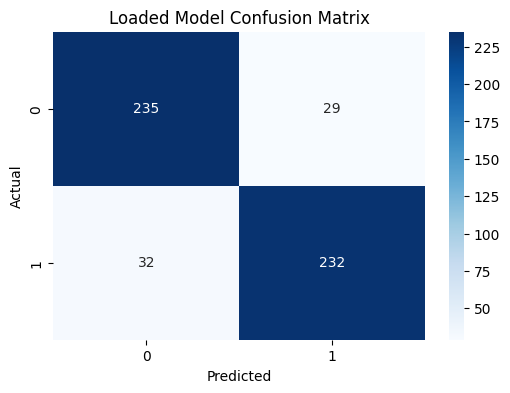

In [ ]:
import joblib
import os
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best model
model_path = "../models/best_signature_model.joblib"
if os.path.exists(model_path):
    loaded_model = joblib.load(model_path)
    print("Model loaded successfully.")

    # Evaluate the loaded model on the test set
    y_pred_loaded = loaded_model.predict(X_test)

    print("\nClassification Report for the loaded model:")
    print(classification_report(y_test, y_pred_loaded))

    if hasattr(loaded_model, "predict_proba"):
        y_prob_loaded = loaded_model.predict_proba(X_test)[:, 1]
        auc_loaded = roc_auc_score(y_test, y_prob_loaded)
        print(f"AUC for the loaded model: {auc_loaded:.4f}")
    else:
        print("Loaded model does not have predict_proba for AUC calculation.")



    cm_loaded = confusion_matrix(y_test, y_pred_loaded)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_loaded, annot=True, fmt="d", cmap="Blues")
    plt.title("Loaded Model Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

else:
    print(f"Model file not found at {model_path}")

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Assuming y_test and y_pred_loaded are available from the previous cell execution
report = classification_report(y_test, y_pred_loaded, output_dict=True)

metrics_data = {
    "Metric": ["Accuracy", "Precision (Forged)", "Recall (Forged)", "F1-Score (Forged)",
               "Precision (Genuine)", "Recall (Genuine)", "F1-Score (Genuine)", "AUC"],
    "Score": [
        report['accuracy'],
        report['0']['precision'],
        report['0']['recall'],
        report['0']['f1-score'],
        report['1']['precision'],
        report['1']['recall'],
        report['1']['f1-score'],
        auc_loaded if 'auc_loaded' in locals() else 'N/A' # Include AUC if calculated
    ]
}

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)

,Metric,Score
0,Accuracy,0.884470
1,Precision (Forged),0.880150
2,Recall (Forged),0.890152
3,F1-Score (Forged),0.885122
4,Precision (Genuine),0.888889
5,Recall (Genuine),0.878788
6,F1-Score (Genuine),0.883810
7,AUC,0.954947


##Testing on new image

In [ ]:
import joblib
import numpy as np
from preprocess import preprocess_image
from features import extract_features

model_path = "../models/best_signature_model.joblib"
model = joblib.load(model_path)
print("Model loaded successfully!")


test_image_path = "/content/2.jpg"

# Preprocess and extract features
img = preprocess_image(test_image_path)
features = extract_features(img).reshape(1, -1)


prob = model.predict_proba(features)[0][1] * 100  # Probability of being genuine
prediction = "Genuine" if prob >= 50 else "Forged"

print(f"\n Signature Test Result:")
print(f"Predicted Class : {prediction}")
print(f"Genuineness Probability : {prob:.2f}%")


✅ Model loaded successfully!

🖋️ Signature Test Result:
Predicted Class : Genuine
Genuineness Probability : 96.46%


## Imports and Setup

## Data Loading and Preprocessing

In [ ]:
from google.colab import files
model_path = '../models/best_signature_model.joblib'
files.download(model_path)
print(f"Download link generated for {model_path}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download link generated for ../models/best_signature_model.joblib


In [ ]:
from google.colab import files
model_path = '../models/best_signature_model.joblib' # Note the correct path
files.download(model_path)
print(f"Download link generated for {model_path}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download link generated for ../models/best_signature_model.joblib


# Task
Optimize the machine learning model to improve prediction accuracy while preventing overfitting.

## Explore hyperparameter tuning

### Subtask:
Use GridSearchCV to find the best hyperparameters for the SVM model.


**Reasoning**:
The current subtask is to use GridSearchCV to find the best hyperparameters for the SVM model. This involves importing GridSearchCV, defining a parameter grid, creating and fitting the GridSearchCV object, and printing the best parameters.



Best parameters found by GridSearchCV:
{'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
Best cross-validation AUC score:
0.8994611419593662

Classification Report for the best SVM model:
              precision    recall  f1-score   support

           0       1.00      0.02      0.03       264
           1       0.50      1.00      0.67       264

    accuracy                           0.51       528
   macro avg       0.75      0.51      0.35       528
weighted avg       0.75      0.51      0.35       528

AUC for the best SVM model: 0.5113


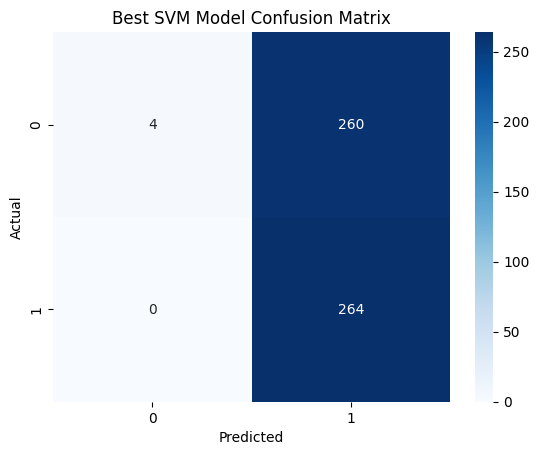

Equal Error Rate (EER) for the best SVM model: 49.43%


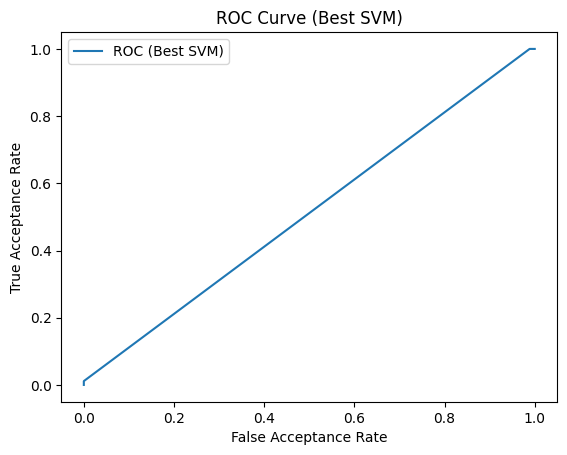

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVM (reduced for faster execution)
param_grid = {
    'clf__C': [1, 10], # Reduced C values
    'clf__gamma': [0.1, 0.01], # Reduced gamma values
    'clf__kernel': ['rbf']
}

# Create the SVM pipeline
svm_pipe = make_pipeline(SVC(probability=True, class_weight='balanced'))

# Create the GridSearchCV object
grid_search = GridSearchCV(svm_pipe, param_grid, cv=3, scoring='roc_auc', n_jobs=-1) # Reduced cross-validation folds

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)
print("Best cross-validation AUC score:")
print(grid_search.best_score_)

# Evaluate the best model on the test set
best_svm_model = grid_search.best_estimator_
y_pred_best_svm = best_svm_model.predict(X_test)
y_prob_best_svm = best_svm_model.predict_proba(X_test)[:, 1]

print("\nClassification Report for the best SVM model:")
print(classification_report(y_test, y_pred_best_svm))
print(f"AUC for the best SVM model: {roc_auc_score(y_test, y_prob_best_svm):.4f}")

cm_best_svm = confusion_matrix(y_test, y_pred_best_svm)
sns.heatmap(cm_best_svm, annot=True, fmt="d", cmap="Blues")
plt.title("Best SVM Model Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# Compute FAR / FRR / EER for the best SVM model
y_score_best_svm = best_svm_model.predict_proba(X_test)[:,1]
fpr_best_svm, tpr_best_svm, thr_best_svm = roc_curve(y_test, y_score_best_svm)
FAR_best_svm = fpr_best_svm
FRR_best_svm = 1 - tpr_best_svm
eer_index_best_svm = np.argmin(np.abs(FAR_best_svm - FRR_best_svm))
EER_best_svm = (FAR_best_svm[eer_index_best_svm] + FRR_best_svm[eer_index_best_svm]) / 2
print(f"Equal Error Rate (EER) for the best SVM model: {EER_best_svm*100:.2f}%")

plt.plot(FAR_best_svm, 1-FRR_best_svm, label='ROC (Best SVM)')
plt.xlabel('False Acceptance Rate')
plt.ylabel('True Acceptance Rate')
plt.title('ROC Curve (Best SVM)')
plt.legend()
plt.show()